# LangChain Expression Language (LCEL)

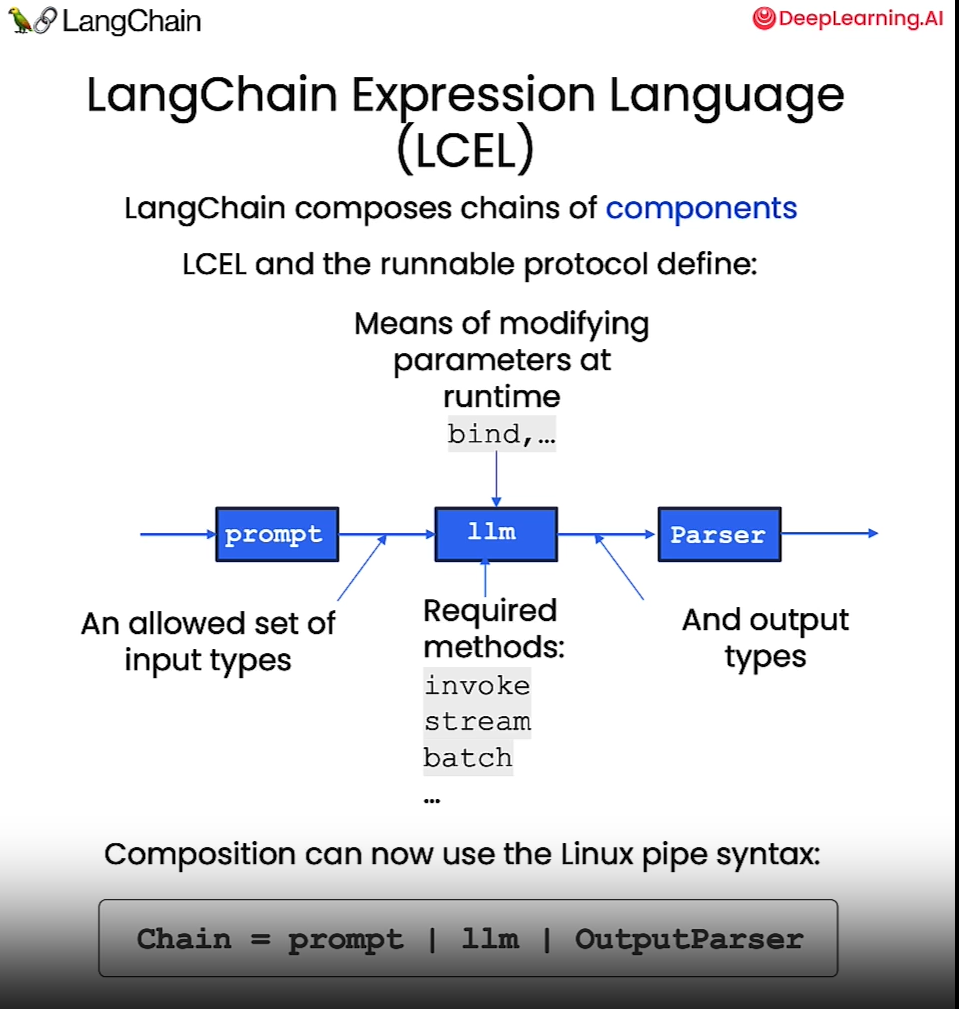

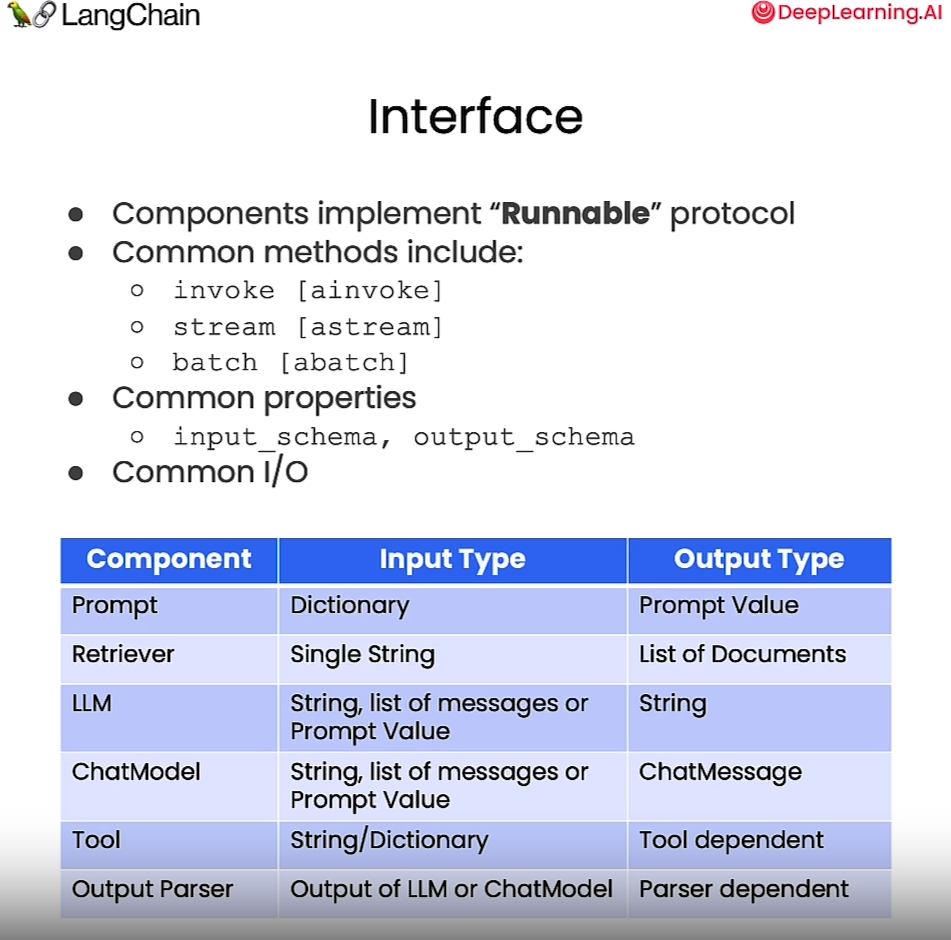

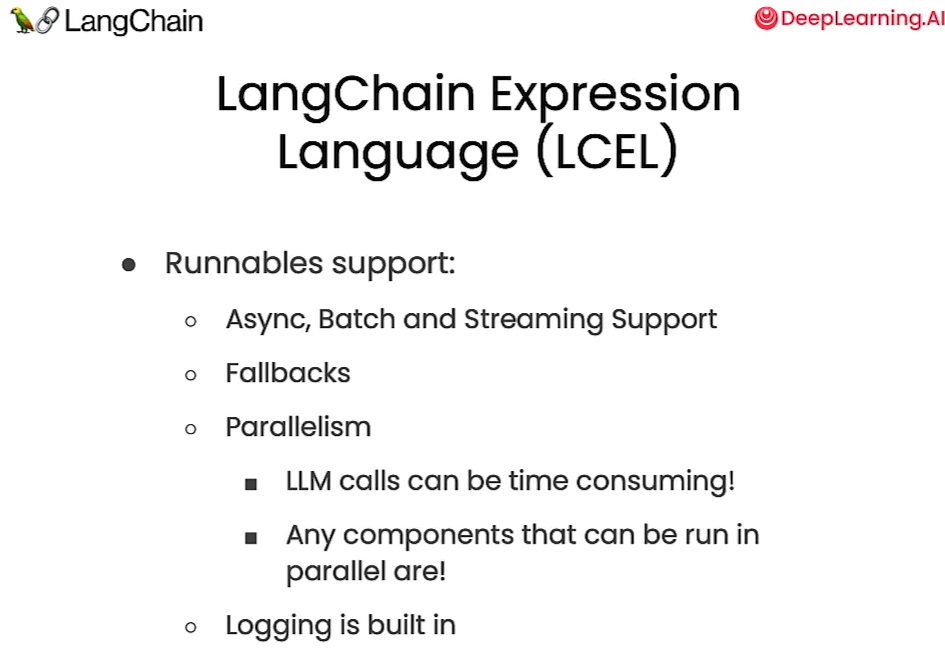

In [ ]:
import os
import openai

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
openai.api_key = os.environ['OPENAI_API_KEY']

In [ ]:
#!pip install pydantic==1.10.8

In [ ]:
from langchain.prompts import ChatPromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain.schema.output_parser import StrOutputParser

## Simple Chain

In [ ]:
prompt = ChatPromptTemplate.from_template(
    "tell me a short joke about {topic}"
)
model = ChatOpenAI()
output_parser = StrOutputParser()

In [ ]:
chain = prompt | model | output_parser

In [ ]:
chain.invoke({"topic": "bears"})

## More complex chain

And Runnable Map to supply user-provided inputs to the prompt.

In [ ]:
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import DocArrayInMemorySearch

In [ ]:
vectorstore = DocArrayInMemorySearch.from_texts(
    ["harrison worked at kensho", "bears like to eat honey"],
    embedding=OpenAIEmbeddings()
)
retriever = vectorstore.as_retriever()

In [ ]:
retriever.get_relevant_documents("where did harrison work?")

In [ ]:
retriever.get_relevant_documents("what do bears like to eat")

In [ ]:
template = """Answer the question based only on the following context:
{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

In [ ]:
from langchain.schema.runnable import RunnableMap

In [ ]:
chain = RunnableMap({
    "context": lambda x: retriever.get_relevant_documents(x["question"]),
    "question": lambda x: x["question"]
}) | prompt | model | output_parser

In [ ]:
chain.invoke({"question": "where did harrison work?"})

In [ ]:
inputs = RunnableMap({
    "context": lambda x: retriever.get_relevant_documents(x["question"]),
    "question": lambda x: x["question"]
})

In [ ]:
inputs.invoke({"question": "where did harrison work?"})

## Bind

and OpenAI Functions

In [ ]:
functions = [
    {
      "name": "weather_search",
      "description": "Search for weather given an airport code",
      "parameters": {
        "type": "object",
        "properties": {
          "airport_code": {
            "type": "string",
            "description": "The airport code to get the weather for"
          },
        },
        "required": ["airport_code"]
      }
    }
  ]

In [ ]:
prompt = ChatPromptTemplate.from_messages(
    [
        ("human", "{input}")
    ]
)
model = ChatOpenAI(temperature=0).bind(functions=functions)

In [ ]:
runnable = prompt | model

In [ ]:
runnable.invoke({"input": "what is the weather in sf"})

In [ ]:
functions = [
    {
      "name": "weather_search",
      "description": "Search for weather given an airport code",
      "parameters": {
        "type": "object",
        "properties": {
          "airport_code": {
            "type": "string",
            "description": "The airport code to get the weather for"
          },
        },
        "required": ["airport_code"]
      }
    },
        {
      "name": "sports_search",
      "description": "Search for news of recent sport events",
      "parameters": {
        "type": "object",
        "properties": {
          "team_name": {
            "type": "string",
            "description": "The sports team to search for"
          },
        },
        "required": ["team_name"]
      }
    }
  ]

In [ ]:
model = model.bind(functions=functions)

In [ ]:
runnable = prompt | model

In [ ]:
runnable.invoke({"input": "how did the patriots do yesterday?"})

## Fallbacks

In [ ]:
from langchain.llms import OpenAI
import json

In [ ]:
simple_model = OpenAI(
    temperature=0, 
    max_tokens=1000, 
    model="text-davinci-001"
)
simple_chain = simple_model | json.loads

In [ ]:
challenge = "write three poems in a json blob, where each poem is a json blob of a title, author, and first line"

In [ ]:
simple_model.invoke(challenge)

Note: The next line is expected to fail.

In [ ]:
simple_chain.invoke(challenge)

In [ ]:
model = ChatOpenAI(temperature=0)
chain = model | StrOutputParser() | json.loads

In [ ]:
chain.invoke(challenge)

In [ ]:
final_chain = simple_chain.with_fallbacks([chain])

In [ ]:
final_chain.invoke(challenge)

## Interface

In [ ]:
prompt = ChatPromptTemplate.from_template(
    "Tell me a short joke about {topic}"
)
model = ChatOpenAI()
output_parser = StrOutputParser()

chain = prompt | model | output_parser

In [ ]:
chain.invoke({"topic": "bears"})

In [ ]:
chain.batch([{"topic": "bears"}, {"topic": "frogs"}])

In [ ]:
for t in chain.stream({"topic": "bears"}):
    print(t)

In [ ]:
response = await chain.ainvoke({"topic": "bears"})
response